# Sentiment Analysis 

In the world of computational linguistics, sentiment analysis refers to the process of determining the general views, opinions, and emotions held within a text by analysing how positive or negative the language held within is. . It is a popular and useful tool for getting an idea of how opinions change over time or comparing the general mood between texts. For this reason, it is common to see sentiment analysis used within the world of cultural data science for exploring questions such as “How do opinions on the corona vaccine differ between countries?” or “Are news articles today more ‘doom and gloom’ than they were 20 years ago?”. 

Here, we compare 2 dictionary based sentiment analysis approaches and compare the differing results given by each, due to their indivdiual ways of calculating sentiment. These approaches are SpaCyTextBlob and VADER. 

# SpacyTextBlob

SpaCyTextBlob (TextBlob) is built on top of the NLTK package and returns two properties for a given sentence, paragraph, or document. These are: 


i)	__Polarity__ (runs between -1 and +1 whereby anything below 0 is considered as having negative sentiment and anything above 0 is considered to have positive sentiment). 


ii)	__Subjectivity__ (a float number between 0 and 1 which indicates how subjective or objective a sentence is. Sentences with a high subjectivity score refer to a personal opinion, emotion, or judgement while sentences with low subjectivity are objective or refer to factual information)


It also has an additional parameter called ‘Intensity’ which is used to modify the value of a following word. For example, if there is ‘really’ in front of a word, the intensity function will ‘intensify’ and/or ‘maximise’ the polarity value of the word which proceeds the ‘really’. 


TextBlob uses a method of ‘averaging’ whereby it ignores the syntax and structure of the words and simply computes the average value for the entire sentence.

In [1]:
#Dependencies 
import os
import spacy #The main sentiment analysis sentiment analysis package to be used 
import pandas as pd #For working with dataframes and reading the data 
from spacytextblob.spacytextblob import SpacyTextBlob
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
#Add spacytextblob to the nlp pipeline
nlp = spacy.load("en_core_web_sm") #We're using the English small library 
spacy_text_blob = SpacyTextBlob() #This is taken from the spacy website 
nlp.add_pipe(spacy_text_blob) 

In [2]:
data_path = "data/abcnews-date-text.csv"

In [4]:
#Load in the data as a dataframe
data = pd.read_csv(data_path)

In [5]:
data #we have a publishing date and headline text 

,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit
3,20030219,air nz staff in aust strike for pay rise
4,20030219,air nz strike to affect australian travellers
...,...,...
1226253,20201231,what abc readers learned from 2020 looking bac...
1226254,20201231,what are the south african and uk variants of ...
1226255,20201231,what victorias coronavirus restrictions mean f...
1226256,20201231,whats life like as an american doctor during c...


In [7]:
#We'll also just create a subset of the data to run the script on for now 
#We'll take 10,000 headlines from a chunk in the middle of the data 
subset_data = data[15000:25000]

#And save it to our output folder 
subset_csv_path = os.path.join("data", "subset_data.csv")
subset_data.to_csv(subset_csv_path, index = False)

In [8]:
#Beware - this takes some time to run! 
sentiment_tracker = []

# for every headline in data frame (we're looking at docs, not sentences)
for doc in nlp.pipe(data["headline_text"], batch_size = 10000): 
    # calculate the sentiment of the doc (headline)
    sentiment = doc._.sentiment.polarity
    # append this to sentiment_tracker list
    sentiment_tracker.append(sentiment)

In [9]:
# append the sentiment_tracker list to the dataframe and save as output csv file in sentiment_plots
data.insert(len(data.columns), "sentiment", sentiment_tracker)
output_csv_path = os.path.join("Output", "sentiment_tracker.csv")
data.to_csv(output_csv_path, index = False)

In [10]:
# Next, create a sentiment dataframe with date as the index and sentiment as a column to calculate means based on date
df_sentiment = pd.DataFrame(
    {"sentiment": sentiment_tracker}, # create a column to hold sentiment scores 
    index = pd.to_datetime(data["publish_date"], format='%Y%m%d', errors='ignore')) # index the date using to_datetime

In [11]:
#Inspect the dataframe 
df_sentiment

,sentiment
publish_date,
2003-02-19,0.000000
2003-02-19,0.250000
2003-02-19,0.000000
2003-02-19,0.000000
2003-02-19,0.000000
...,...
2020-12-31,0.000000
2020-12-31,0.000000
2020-12-31,-0.088068


In [12]:
#Create a column which calculates the 7-day and 30-day rolling averages 
df_sentiment['weekly'] = df_sentiment.sentiment.rolling(7).mean()
df_sentiment['monthly'] = df_sentiment.sentiment.rolling(30).mean()

In [13]:
#Build a function which creates a seaborn rolling average map 
def smoothed_sentiment_textblob(text_date_window):
    if text_date_window == "1-week":
        sns.set_style('darkgrid')
        plt.figure(figsize=(10,6), tight_layout=True)
        ax = sns.lineplot(data=df_sentiment,
                   x='publish_date', y='weekly',
                   label = "7 Day Average",
                   palette='Set2', 
                   linewidth=2.5) 
        ax.set(xlabel="Publish Date", ylabel = "Sentiment Score")
        ax.set(title = "Sentiment over time with a 7 day rolling average")
        ax.grid(color='grey', linestyle='-', linewidth=0.5)
        #save the plot 
        ax.figure.savefig(os.path.join("Output", "TextBlob_weekly_sentiment.png"))
    
    else:
        sns.set_style('darkgrid')
        plt.figure(figsize=(10,6), tight_layout=True)
        ax = sns.lineplot(data=df_sentiment,
                   x='publish_date', y='monthly',
                   label = "7 Day Average",
                   palette='Set2', 
                   linewidth=2.5) 
        ax.set(xlabel="Publish Date", ylabel = "Sentiment Score")
        ax.set(title = "Sentiment over time with a 30 day rolling average")
        ax.grid(color='grey', linestyle='-', linewidth=0.5)
        #save the plot 
        ax.figure.savefig(os.path.join("Output", "TextBlob_monthly_sentiment.png"))
        

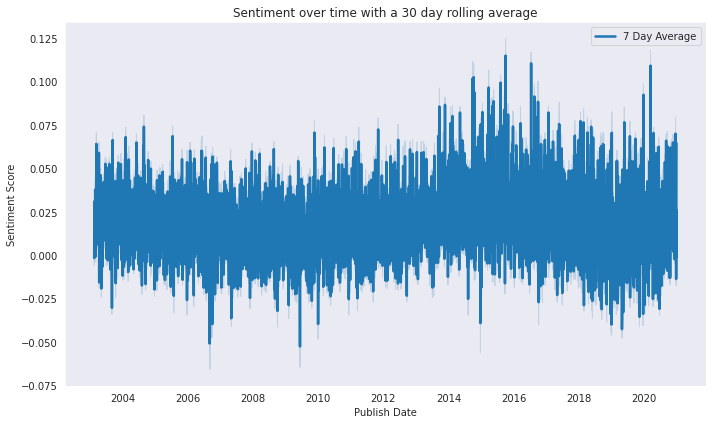

In [14]:
# Plot the monthly rolling average 
smoothed_sentiment_textblob("1-month")

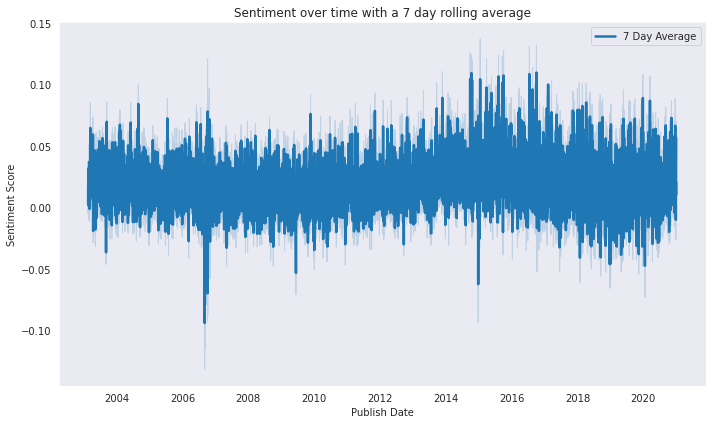

In [15]:
#Plot the weekly rolling average 
smoothed_sentiment_textblob("1-week")

__Setting up for comparison against Vadar__

A key part of our analysis is interested in comparing the SpacyTextBlob approach to NLTK's Vadar approach. To do this, we'll categorise our sentiment scores into 'positive', 'neutral', and 'negative' in a new column of our dataset. 

This way, we can count how many fall into each category

In [16]:
# The next step is to categorise our sentiment so that we can compare it against the vadar sentiment analysis 
df_sentiment['Sentiment_Type']=''
df_sentiment.loc[df_sentiment.sentiment>0,'Sentiment_Type']='positive'
df_sentiment.loc[df_sentiment.sentiment==0,'Sentiment_Type']='neutral'
df_sentiment.loc[df_sentiment.sentiment<0,'Sentiment_Type']='negative'

In [17]:
#Inspect the column - we'll take a slice from the middle
df_sentiment[5000:5010]

,sentiment,weekly,monthly,Sentiment_Type
publish_date,,,,
2003-03-14,-0.312500,-0.025162,-0.002297,negative
2003-03-14,0.000000,-0.025162,-0.002297,neutral
2003-03-14,0.333333,0.022457,0.005481,positive
2003-03-14,0.000000,0.022457,0.005481,neutral
2003-03-14,0.000000,0.022457,0.005481,neutral
2003-03-14,0.000000,0.022457,0.001314,neutral
2003-03-14,0.000000,0.002976,0.001314,neutral
2003-03-14,0.000000,0.047619,0.001314,neutral
2003-03-14,0.166667,0.071429,0.006870,positive


Our column is looking good, so the next thing we'd want to do is create a barchart. We'll employ seaborn again to make the chart more asthetically appealing. 

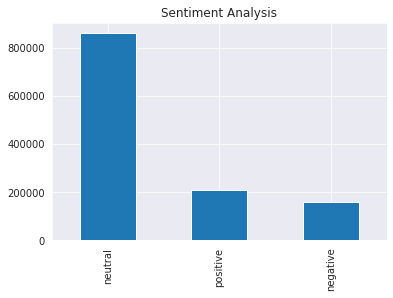

In [21]:
textblob_barplot = df_sentiment.Sentiment_Type.value_counts().plot(kind='bar',title="Sentiment Analysis")
textblob_barplot.figure.savefig(os.path.join("Output", "TextBlob_barplot.png"))

# VADAR Sentiment Analysis 

Vadar is an alternative sentiment analysis library which computes a different kind of sentiment. Unlike SpacyTextBlob which gives an overall 'sentiment' score, Vadar computes a 'positivity', 'negativity', and 'neutral' score as well as a 'compound' - which is a weighted average of the 3. In this way, the compound score given from vadar can be used to compare against SpacyTextBlob. This is always important because we have to know what's going on in our models to be able to trust them! 

In [3]:
#Dependencies
import nltk
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
# create a sentiment intensity analyzer
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /home/cds-
[nltk_data]     au604588/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [4]:
#Create a new dataframe of the same data 
vadar_data = pd.read_csv(data_path)
vadar_data

,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit
3,20030219,air nz staff in aust strike for pay rise
4,20030219,air nz strike to affect australian travellers
...,...,...
1226253,20201231,what abc readers learned from 2020 looking bac...
1226254,20201231,what are the south african and uk variants of ...
1226255,20201231,what victorias coronavirus restrictions mean f...
1226256,20201231,whats life like as an american doctor during c...


In [5]:
# Create a new column with the sentiment scores from vadar 
vadar_data['sentiment'] = vadar_data['headline_text'].apply(lambda headline_text: sid.polarity_scores(headline_text))

In [6]:
#Create a columm with just the compound value of the sentiment scores & create categories
vadar_data['compound'] = vadar_data['sentiment'].apply(lambda score_dict: score_dict['compound'])
vadar_data['sentiment_type']=''
vadar_data.loc[vadar_data.compound>0,'sentiment_type']='positive'
vadar_data.loc[vadar_data.compound==0,'sentiment_type']='neutral'
vadar_data.loc[vadar_data.compound<0,'sentiment_type']='negative'

In [7]:
vadar_data

,publish_date,headline_text,sentiment,compound,sentiment_type
0,20030219,aba decides against community broadcasting lic...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral
1,20030219,act fire witnesses must be aware of defamation,"{'neg': 0.255, 'neu': 0.745, 'pos': 0.0, 'comp...",-0.3400,negative
2,20030219,a g calls for infrastructure protection summit,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral
3,20030219,air nz staff in aust strike for pay rise,"{'neg': 0.293, 'neu': 0.707, 'pos': 0.0, 'comp...",-0.2263,negative
4,20030219,air nz strike to affect australian travellers,"{'neg': 0.2, 'neu': 0.8, 'pos': 0.0, 'compound...",-0.1280,negative
...,...,...,...,...,...
1226253,20201231,what abc readers learned from 2020 looking bac...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral
1226254,20201231,what are the south african and uk variants of ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral
1226255,20201231,what victorias coronavirus restrictions mean f...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral
1226256,20201231,whats life like as an american doctor during c...,"{'neg': 0.0, 'neu': 0.762, 'pos': 0.238, 'comp...",0.3612,positive


In [8]:
#create a list from the compound column 
vadar_timeseries = vadar_data["compound"].tolist()

In [9]:
# Then create a dataframe with this list and the publish_date data converted into date form 
vadar_sentiment = pd.DataFrame(
    {"sentiment": vadar_timeseries}, # create a column to hold sentiment scores 
    index = pd.to_datetime(vadar_data["publish_date"], format='%Y%m%d', errors='ignore'))

In [10]:
#Inspect the dataframe 
vadar_sentiment

,sentiment
publish_date,
2003-02-19,0.0000
2003-02-19,-0.3400
2003-02-19,0.0000
2003-02-19,-0.2263
2003-02-19,-0.1280
...,...
2020-12-31,0.0000
2020-12-31,0.0000
2020-12-31,0.0000


In [11]:
#Create a column which calculates the 7-day and 30-day rolling averages 
vadar_sentiment['weekly'] = vadar_sentiment.sentiment.rolling(7).mean()
vadar_sentiment['monthly'] = vadar_sentiment.sentiment.rolling(30).mean()

In [12]:
#Inspect the new columns (we'll just view 5)
vadar_sentiment[5000:5005]

,sentiment,weekly,monthly
publish_date,,,
2003-03-14,0.0000,-0.116343,-0.033820
2003-03-14,0.0000,-0.101671,-0.022487
2003-03-14,0.5994,-0.016043,0.015050
2003-03-14,-0.3818,0.009043,0.009867
2003-03-14,-0.6705,-0.086743,-0.012483


In [13]:
#Creating the rolling plots 

#Build a function which creates a seaborn rolling average map 
def smoothed_sentiment_vadar(text_date_window):
    if text_date_window == "1-week":
        sns.set_style('darkgrid')
        plt.figure(figsize=(10,6), tight_layout=True)
        ax = sns.lineplot(data=vadar_sentiment,
                   x='publish_date', y='weekly',
                   label = "7 Day Average",
                   palette='Set2', 
                   linewidth=2.5) 
        ax.set(xlabel="Publish_date", ylabel = "Sentiment Score")
        ax.set(title = "Sentiment over time with a 7 day rolling average")
        ax.grid(color='grey', linestyle='-', linewidth=0.5)
        #save the plot 
        ax.figure.savefig(os.path.join("Output", "VADAR_weekly_sentiment.png"))
    
    else:
        sns.set_style('darkgrid')
        plt.figure(figsize=(10,6), tight_layout=True)
        ax = sns.lineplot(data=vadar_sentiment,
                   x='publish_date', y='monthly',
                   label = "7 Day Average",
                   palette='Set2', 
                   linewidth=2.5) 
        ax.set(xlabel="Publish_date", ylabel = "Sentiment Score")
        ax.set(title = "Sentiment over time with a 30 day rolling average")
        ax.grid(color='grey', linestyle='-', linewidth=0.5)
        #save the plot 
        ax.figure.savefig(os.path.join("Output", "VADAR_monthly_sentiment.png"))
        

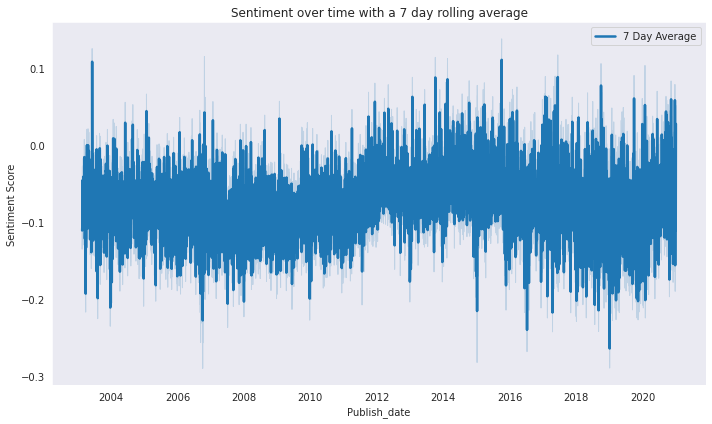

In [14]:
smoothed_sentiment_vadar("1-week")

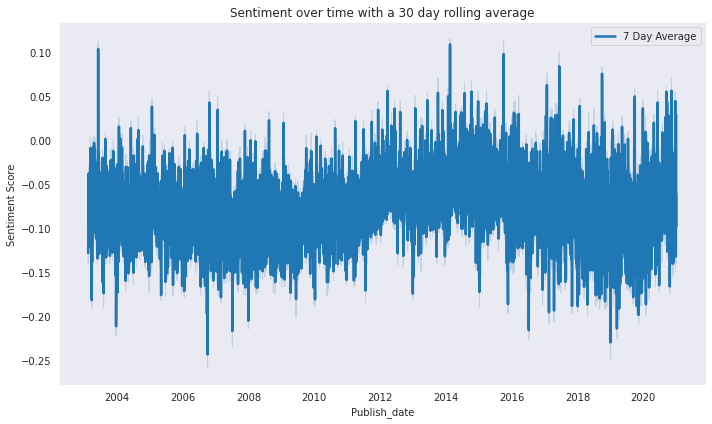

In [15]:
smoothed_sentiment_vadar("1-month")

__Boxplot of Positive, Neutral, and Negative scores__

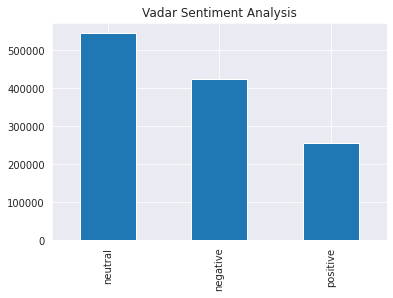

In [17]:
VADER_boxplot = vadar_data.sentiment_type.value_counts().plot(kind='bar',title="Vadar Sentiment Analysis")
VADER_boxplot.figure.savefig(os.path.join("Output", "VADER_barplot.png"))